In [ ]:
import pandas as pd
df = pd.read_csv("/content/nifty.csv")

In [ ]:
df.head()

,Index Name,Date,Open,High,Low,Close
0,NIFTY 50,19-Dec-23,21477.65,21505.05,21337.75,21453.10
1,NIFTY 50,18-Dec-23,21434.80,21482.80,21365.35,21418.65
2,NIFTY 50,15-Dec-23,21287.45,21492.30,21235.30,21456.65
3,NIFTY 50,14-Dec-23,21110.40,21210.90,21074.45,21182.70
4,NIFTY 50,13-Dec-23,20929.75,20950.00,20769.50,20926.35


In [ ]:
import numpy as np

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df=df.sort_values(by=["Date"],ascending=True)
date=df["Date"][60:]
df.set_index('Date', inplace=True)
df.head()

<ipython-input-142-dec05f5a137d>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


,Index Name,Open,High,Low,Close
Date,,,,,
2000-01-03,NIFTY 50,1482.15,1592.90,1482.15,1592.2
2000-01-04,NIFTY 50,1594.40,1641.95,1594.40,1638.7
2000-01-05,NIFTY 50,1634.55,1635.50,1555.05,1595.8
2000-01-06,NIFTY 50,1595.80,1639.00,1595.80,1617.6
2000-01-07,NIFTY 50,1616.60,1628.25,1597.20,1613.3


In [ ]:
high_series = df['High']
low_series = df["Low"]
# Perform differencing to remove trend
differenced_high_series = high_series.diff().dropna()
differenced_low_series = low_series.diff().dropna()
df["differenceHigh"]=differenced_high_series
df["differenceLow"]=differenced_low_series
df=df[1:]

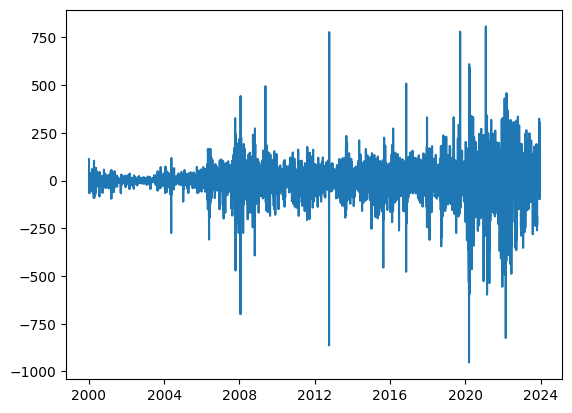

In [ ]:
plt.plot(differenced_high_series)

In [ ]:
# Create a new dataframe with only the high column
data = df.filter(['differenceHigh'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

5662

In [ ]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.54353636],
       [0.50450134],
       [0.51149951],
       ...,
       [0.70695597],
       [0.50235617],
       [0.52468702]])

In [ ]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

5602/5602 [==============================] - 367s 65ms/step - loss: 0.0033


In [ ]:
print( model.predict(x_train))

176/176 [==============================] - 8s 44ms/step
[[0.5215813 ]
 [0.52154034]
 [0.5218309 ]
 ...
 [0.5229709 ]
 [0.5221371 ]
 [0.5237868 ]]
298


In [ ]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

10/10 [==============================] - 0s 41ms/step


104.50691384979592

<ipython-input-71-9bea1eb636aa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


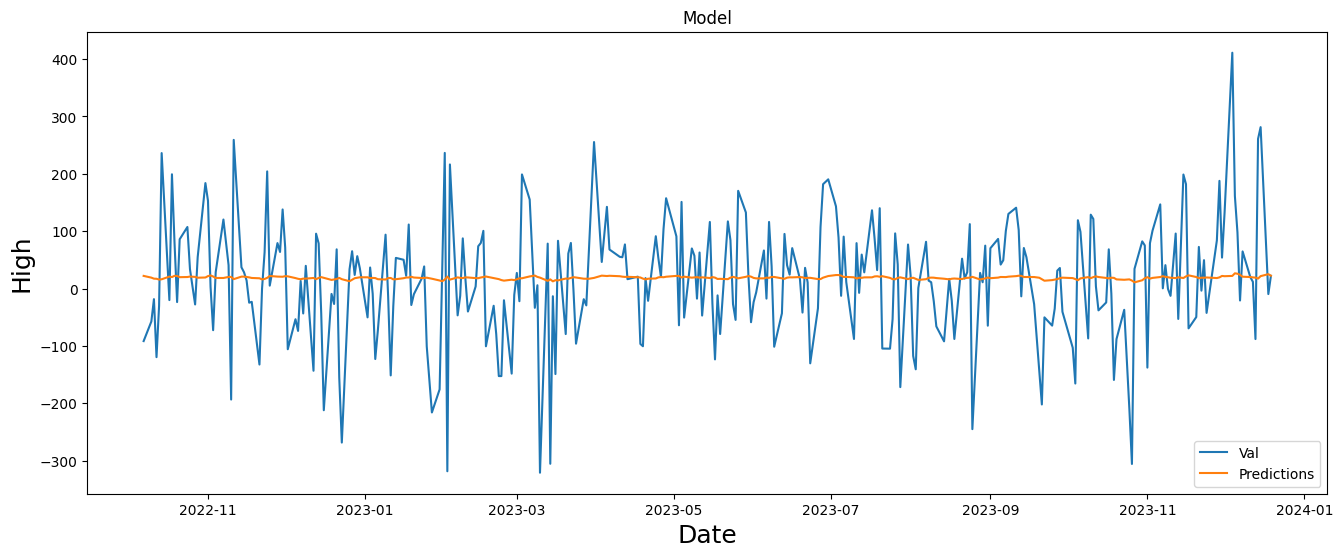

In [ ]:
# Plot the data
import matplotlib.pyplot as plt
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
high=valid['Predictions']
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('High Diff', fontsize=18)

plt.plot(valid[['differenceHigh', 'Predictions']])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()

[array([17450.973], dtype=float32), array([17356.473], dtype=float32), array([17297.512], dtype=float32), array([17278.97], dtype=float32), array([17158.111], dtype=float32), array([17128.625], dtype=float32), array([17369.475], dtype=float32), array([17348.686], dtype=float32), array([17550.098], dtype=float32), array([17629.607], dtype=float32), array([17604.086], dtype=float32), array([17690.357], dtype=float32), array([17798.555], dtype=float32), array([17831.932], dtype=float32), array([17802.9], dtype=float32), array([17858.271], dtype=float32), array([18044.592], dtype=float32), array([18198.74], dtype=float32), array([18199.877], dtype=float32), array([18124.83], dtype=float32), array([18153.643], dtype=float32), array([18275.83], dtype=float32), array([18316.773], dtype=float32), array([18119.64], dtype=float32), array([18383.176], dtype=float32), array([18420.387], dtype=float32), array([18448.252], dtype=float32), array([18461.738], dtype=float32), array([18436.174], dtype=f

<ipython-input-135-d5016c0175cc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["High"]=df[-298:]["High"].values
<ipython-input-135-d5016c0175cc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["PredHigh"]=predicted_high_series


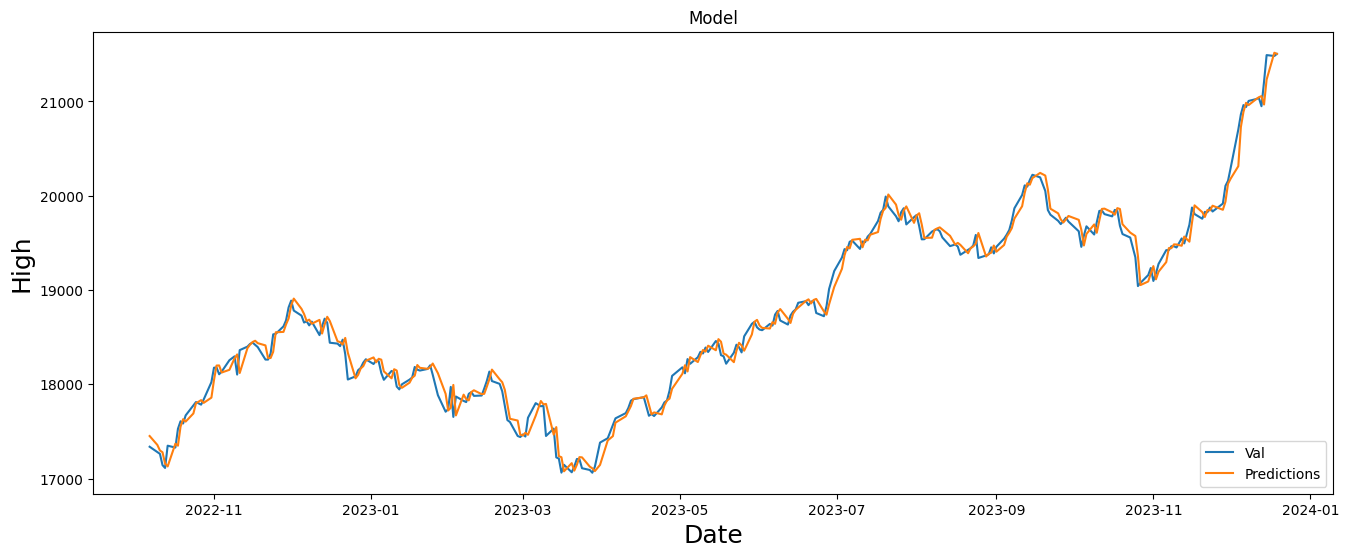

In [ ]:
predicted_high_series = [df[(-299+i):(-298+i)]["High"].values[0]+predictions[i] for i in range(len(predictions))]
valid["High"]=df[-298:]["High"].values
valid["PredHigh"]=predicted_high_series

plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('High', fontsize=18)

plt.plot(valid[["High","PredHigh"]])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Create a new dataframe with only the 'Close column
data1 = df.filter(['differenceLow'])
# Convert the dataframe to a numpy array
dataset1 = data1.values
# Get the number of rows to train the model on
training_data_len1 = int(np.ceil( len(dataset1) * .95 ))

training_data_len1

5662

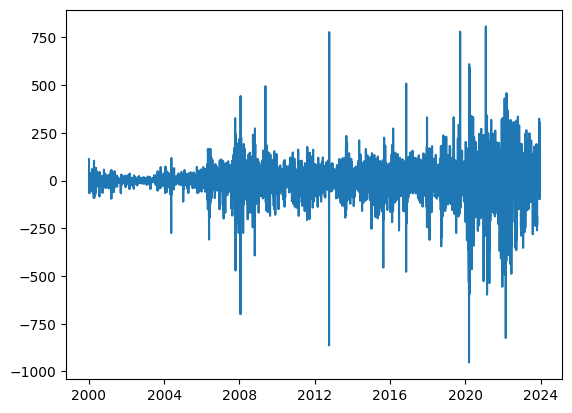

In [ ]:
plt.plot(differenced_low_series)

In [ ]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler1 = MinMaxScaler(feature_range=(0,1))
scaled_data1 = scaler1.fit_transform(dataset1)
scaled_data1

array([[0.60508451],
       [0.51896037],
       [0.56446527],
       ...,
       [0.63269422],
       [0.61519671],
       [0.52563556]])

In [ ]:
# Create the training data set
# Create the scaled training data set
train_data1 = scaled_data[0:int(training_data_len1), :]
# Split the data into x_train and y_train data sets
x_train1 = []
y_train1 = []

for i in range(60, len(train_data1)):
    x_train1.append(train_data1[i-60:i, 0])
    y_train1.append(train_data1[i, 0])
    if i<= 61:
        print(x_train1)
        print(y_train1)
        print()

# Convert the x_train and y_train to numpy arrays
x_train1, y_train1 = np.array(x_train1), np.array(y_train1)

# Reshape the data
x_train1 = np.reshape(x_train1, (x_train1.shape[0], x_train1.shape[1], 1))
# x_train.shape

[array([0.54353636, 0.50450134, 0.51149951, 0.501477  , 0.53284569,
       0.49342383, 0.503165  , 0.53688986, 0.47826699, 0.53790969,
       0.47155015, 0.52964552, 0.50900267, 0.49644816, 0.52204951,
       0.48698832, 0.52303418, 0.49310733, 0.500211  , 0.47795049,
       0.54543536, 0.51663384, 0.51230834, 0.52630468, 0.53027852,
       0.54810803, 0.496413  , 0.54979603, 0.52577718, 0.47320298,
       0.50784217, 0.51628218, 0.51680968, 0.51160501, 0.51835701,
       0.53513152, 0.46223097, 0.51287101, 0.48765649, 0.5488817 ,
       0.47007315, 0.54135603, 0.47056548, 0.51033901, 0.51596568,
       0.53323252, 0.45769447, 0.5007385 , 0.48410466, 0.45720214,
       0.5509917 , 0.50218033, 0.48375299, 0.52222535, 0.52676185,
       0.47401182, 0.51881418, 0.49676466, 0.53263469, 0.47278098])]
[0.5003868335912224]

[array([0.54353636, 0.50450134, 0.51149951, 0.501477  , 0.53284569,
       0.49342383, 0.503165  , 0.53688986, 0.47826699, 0.53790969,
       0.47155015, 0.52964552, 0.509

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model1 = Sequential()
model1.add(LSTM(128, return_sequences=True, input_shape= (x_train1.shape[1], 1)))
model1.add(LSTM(64, return_sequences=False))
model1.add(Dense(25))
model1.add(Dense(1))

# Compile the model
model1.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model1.fit(x_train1, y_train1, batch_size=1, epochs=1)

5602/5602 [==============================] - 359s 63ms/step - loss: 0.0034


In [ ]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data1 = scaled_data1[training_data_len1 - 60: , :]
# Create the data sets x_test and y_test
x_test1 = []
y_test1 = dataset1[training_data_len1:, :]
for i in range(60, len(test_data1)):
    x_test1.append(test_data1[i-60:i, 0])

# Convert the data to a numpy array
x_test1 = np.array(x_test1)

# Reshape the data
x_test1 = np.reshape(x_test1, (x_test1.shape[0], x_test1.shape[1], 1 ))

# Get the models predicted price values
predictions1 = model1.predict(x_test1)
predictions1 = scaler1.inverse_transform(predictions1)

# Get the root mean squared error (RMSE)
rmse1 = np.sqrt(np.mean(((predictions1 - y_test1) ** 2)))
rmse1

10/10 [==============================] - 1s 36ms/step


124.97906732420465

<ipython-input-153-8e65d0c30fb7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid1['Predictions'] = predictions1


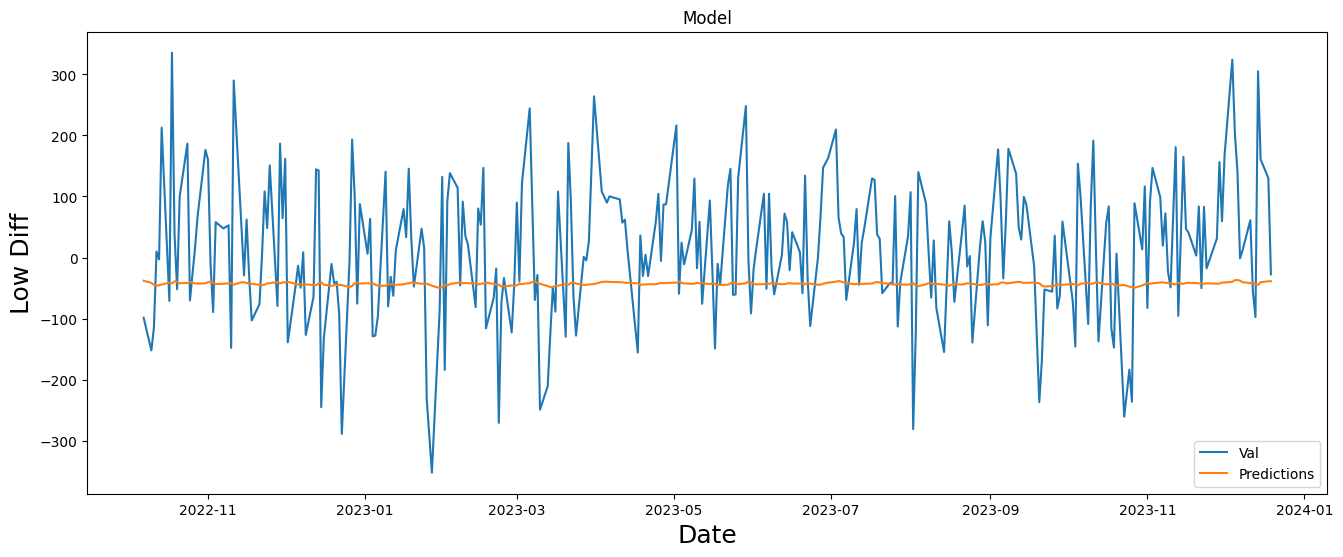

In [ ]:
# Plot the data
import matplotlib.pyplot as plt
train1 = data1[:training_data_len1]
valid1 = data1[training_data_len1:]
valid1['Predictions'] = predictions1

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Low Diff', fontsize=18)

plt.plot(valid1[['differenceLow', 'Predictions']])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()

<ipython-input-154-8a8b0766e692>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Low"]=df[-298:]["Low"].values
<ipython-input-154-8a8b0766e692>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["PredLow"]=predicted_high_series


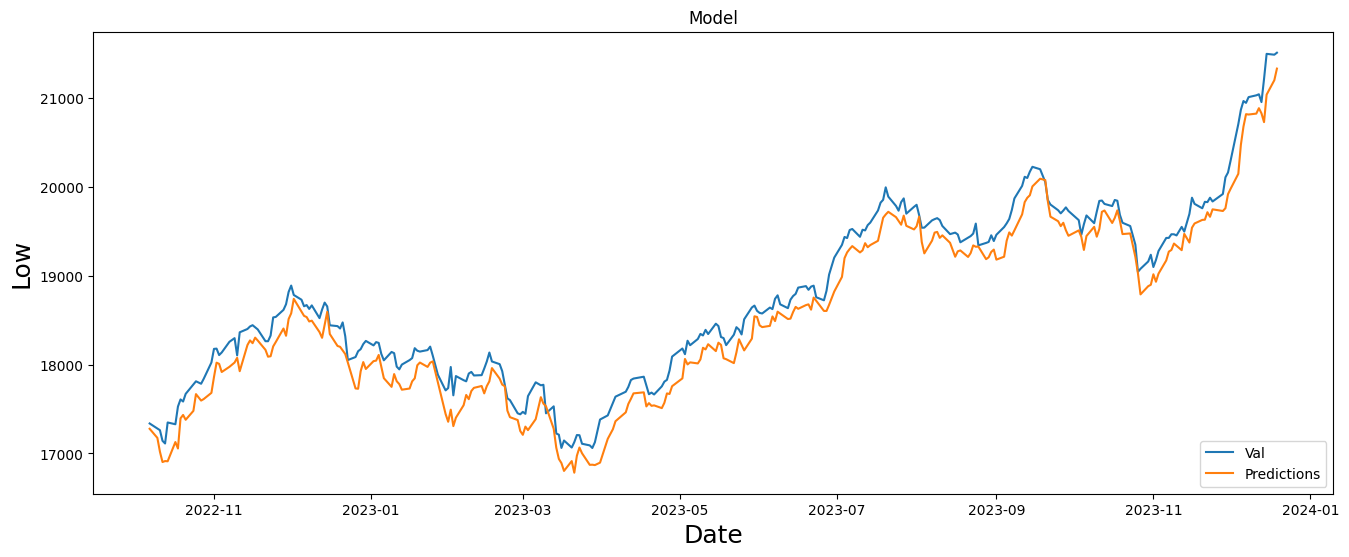

In [ ]:
predicted_high_series = [df[(-299+i):(-298+i)]["Low"].values[0]+predictions1[i] for i in range(len(predictions1))]
valid["Low"]=df[-298:]["Low"].values
valid["PredLow"]=predicted_high_series

plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Low', fontsize=18)

plt.plot(valid[["High","PredLow"]])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# rmserange = np.sqrt(np.mean((((dataset-dataset1).reshape(-1)[-298:] - (high-low)) ** 2)))
# print(rmserange)
# plt.plot(pd.DataFrame({"actual":(dataset-dataset1).reshape(-1)[-298:],"predicted":high-low}))
# plt.legend([ 'Actual', 'Predicted'], loc='lower right')
# plt.show()

In [ ]:
# df1=pd.read_csv("/content/^NSEI.csv")

# testlow=df1[["Low"]].values
# scaled_testlow = scaler1.transform(testlow).reshape(-1)
# testlow=testlow.reshape(-1)
# x_testlow = []
# y_testlow = testlow[60:]
# for i in range(60, len(testlow)):
#     x_testlow.append(scaled_testlow[i-60:i])
# x_testlow = np.array(x_testlow)
# x_testlow = np.reshape(x_testlow, (x_testlow.shape[0], x_testlow.shape[1], 1 ))
# predictions_low = model1.predict(x_testlow)
# predictions_low = scaler1.inverse_transform(predictions_low)

# new=pd.DataFrame({'Predictions':predictions_low.reshape(-1),"Low":testlow[60:]})
# low=new['Predictions']
# # Visualize the data
# plt.figure(figsize=(16,6))
# plt.title('Model')
# plt.xlabel('Date', fontsize=18)
# plt.ylabel('Low', fontsize=18)

# plt.plot(new[['Low', 'Predictions']])
# plt.legend([ 'Actual', 'Predictions'], loc='lower right')
# plt.show()


In [ ]:
df_weekly=pd.DataFrame({
    "Date":date,
    "High":high,
    "Low":low
})
df_weekly.set_index('Date', inplace=True)
df_weekly = df.resample('W').agg({ 'High': 'max', 'Low': 'min'}).reset_index()

weekly_df_actual = pd.read_csv("/content/nifty.csv")
weekly_df_actual['Date'] = pd.to_datetime(weekly_df_actual['Date'])
weekly_df_actual=weekly_df_actual.sort_values(by=["Date"],ascending=True)
weekly_df_actual = weekly_df_actual.drop(weekly_df_actual.index[:60])
weekly_df_actual.set_index('Date', inplace=True)
weekly_df_actual = weekly_df_actual.resample('W').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'}).reset_index()

187.74714483975575


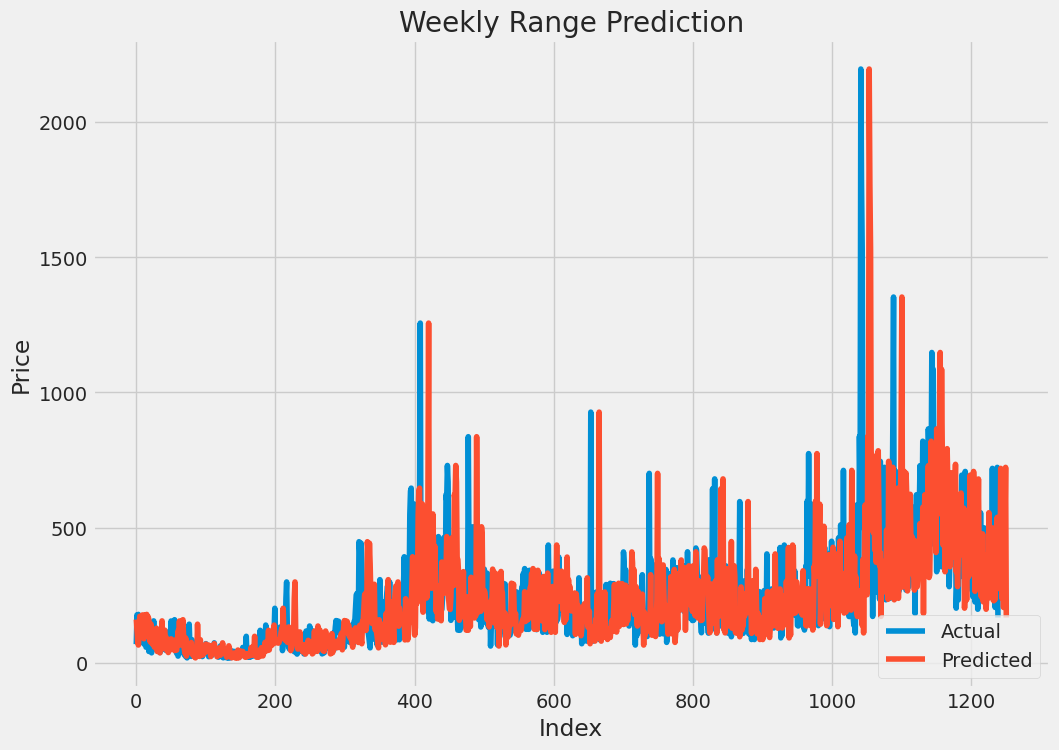

In [ ]:
rmserange = np.sqrt(np.mean((weekly_df_actual["High"]-weekly_df_actual["Low"] - (df_weekly["High"]-df_weekly["Low"])) ** 2))
print(rmserange)
plt.figure(figsize=(11, 8))
plt.plot(pd.DataFrame({"actual":weekly_df_actual["High"]-weekly_df_actual["Low"],"predicted":df_weekly["High"]-df_weekly["Low"]}))
plt.title("Weekly Range Prediction")
plt.ylabel("Price")
plt.xlabel("Index")
plt.legend([ 'Actual', 'Predicted'], loc='lower right')
plt.show()

**Predict with weekly data only**

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("/content/nifty.csv")

In [ ]:
# Create a new dataframe with only the 'Close column
df['Date'] = pd.to_datetime(df['Date'])
df=df.sort_values(by=["Date"],ascending=True)
df.set_index('Date', inplace=True)
df_weekly = df.resample('W').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'}).reset_index()
df_weekly.head()

,Date,Open,High,Low,Close
0,2000-01-09,1482.15,1641.95,1482.15,1613.3
1,2000-01-16,1615.65,1671.15,1548.25,1622.7
2,2000-01-23,1623.50,1668.45,1587.85,1620.6
3,2000-01-30,1623.05,1645.00,1579.55,1599.1
4,2000-02-06,1598.35,1621.35,1521.40,1599.7


In [ ]:
data=df_weekly.filter(["High"])
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

1189

In [ ]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.035252  ],
       [0.03667024],
       [0.03653911],
       ...,
       [0.97576607],
       [0.99938073],
       [1.        ]])

In [ ]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.035252  , 0.03667024, 0.03653911, 0.03540014, 0.03425147,
       0.04155152, 0.04270748, 0.04381001, 0.04211735, 0.04124067,
       0.03540014, 0.03463274, 0.03367106, 0.03117699, 0.03500916,
       0.02925848, 0.02621315, 0.02488962, 0.02527818, 0.02096032,
       0.01761143, 0.02402265, 0.02765325, 0.0274274 , 0.03025659,
       0.02863679, 0.02985832, 0.03150241, 0.02895249, 0.02335725,
       0.0208049 , 0.02174958, 0.02170587, 0.0234471 , 0.02336939,
       0.02608202, 0.02748326, 0.02428007, 0.01889125, 0.01895682,
       0.01798056, 0.01518537, 0.01344171, 0.01617619, 0.01753858,
       0.0171913 , 0.01609362, 0.01772071, 0.01960765, 0.02201915,
       0.01988693, 0.01698731, 0.02016621, 0.02030463, 0.02027063,
       0.02224742, 0.02330868, 0.02429222, 0.02461521, 0.02315082])]
[0.02347867054577952]

[array([0.035252  , 0.03667024, 0.03653911, 0.03540014, 0.03425147,
       0.04155152, 0.04270748, 0.04381001, 0.04211735, 0.04124067,
       0.03540014, 0.03463274, 0.03

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1129/1129 [==============================] - 66s 54ms/step - loss: 0.0015


In [ ]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2/2 [==============================] - 1s 34ms/step


489.6056488792333

<ipython-input-184-34bc19edf812>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


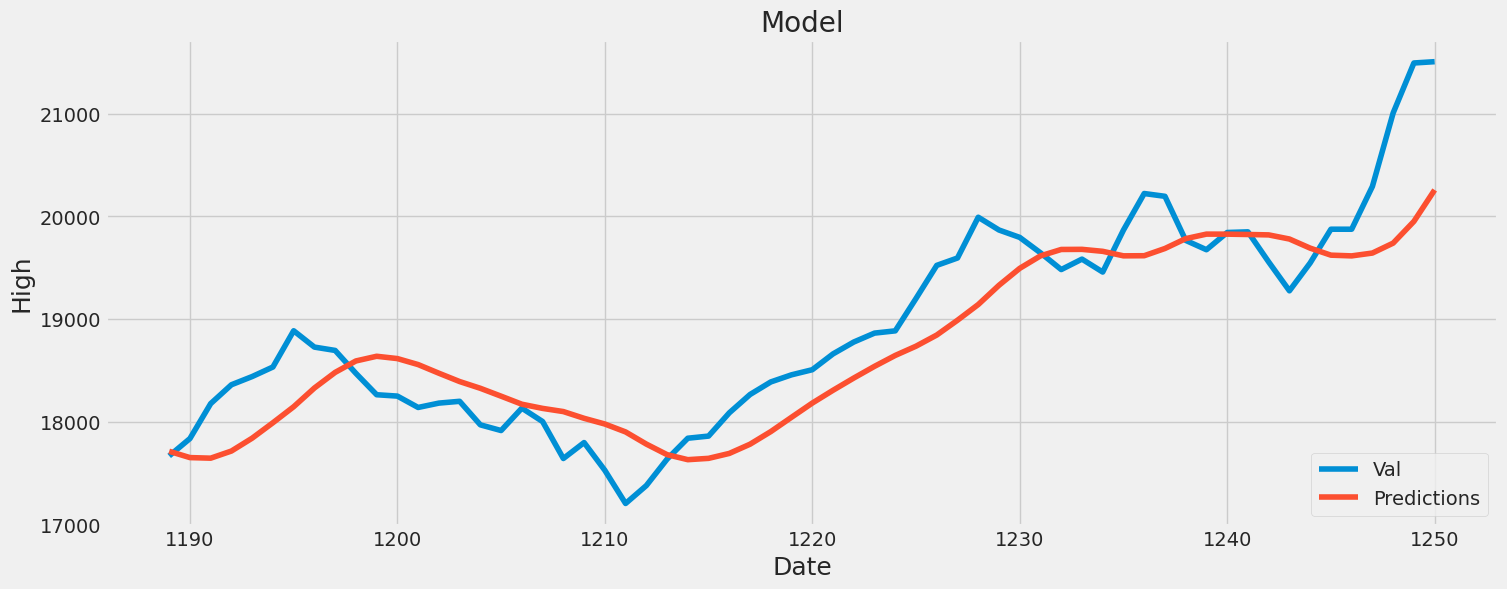

In [ ]:
# Plot the data
import matplotlib.pyplot as plt
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
high=valid['Predictions']
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('High', fontsize=18)

plt.plot(valid[['High', 'Predictions']])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Create a new dataframe with only the 'Close column
data1 = df_weekly.filter(['Low'])
# Convert the dataframe to a numpy array
dataset1 = data1.values
# Get the number of rows to train the model on
training_data_len1 = int(np.ceil( len(dataset1) * .95 ))

training_data_len1

1189

In [ ]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler1 = MinMaxScaler(feature_range=(0,1))
scaled_data1 = scaler1.fit_transform(dataset1)
scaled_data1

array([[0.03085739],
       [0.0340837 ],
       [0.03601656],
       ...,
       [0.95948809],
       [0.97226398],
       [1.        ]])

In [ ]:
# Create the training data set
# Create the scaled training data set
train_data1 = scaled_data[0:int(training_data_len1), :]
# Split the data into x_train and y_train data sets
x_train1 = []
y_train1 = []

for i in range(60, len(train_data1)):
    x_train1.append(train_data1[i-60:i, 0])
    y_train1.append(train_data1[i, 0])
    if i<= 61:
        print(x_train1)
        print(y_train1)
        print()

# Convert the x_train and y_train to numpy arrays
x_train1, y_train1 = np.array(x_train1), np.array(y_train1)

# Reshape the data
x_train1 = np.reshape(x_train1, (x_train1.shape[0], x_train1.shape[1], 1))
# x_train.shape

[array([0.035252  , 0.03667024, 0.03653911, 0.03540014, 0.03425147,
       0.04155152, 0.04270748, 0.04381001, 0.04211735, 0.04124067,
       0.03540014, 0.03463274, 0.03367106, 0.03117699, 0.03500916,
       0.02925848, 0.02621315, 0.02488962, 0.02527818, 0.02096032,
       0.01761143, 0.02402265, 0.02765325, 0.0274274 , 0.03025659,
       0.02863679, 0.02985832, 0.03150241, 0.02895249, 0.02335725,
       0.0208049 , 0.02174958, 0.02170587, 0.0234471 , 0.02336939,
       0.02608202, 0.02748326, 0.02428007, 0.01889125, 0.01895682,
       0.01798056, 0.01518537, 0.01344171, 0.01617619, 0.01753858,
       0.0171913 , 0.01609362, 0.01772071, 0.01960765, 0.02201915,
       0.01988693, 0.01698731, 0.02016621, 0.02030463, 0.02027063,
       0.02224742, 0.02330868, 0.02429222, 0.02461521, 0.02315082])]
[0.02347867054577952]

[array([0.035252  , 0.03667024, 0.03653911, 0.03540014, 0.03425147,
       0.04155152, 0.04270748, 0.04381001, 0.04211735, 0.04124067,
       0.03540014, 0.03463274, 0.03

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model1 = Sequential()
model1.add(LSTM(128, return_sequences=True, input_shape= (x_train1.shape[1], 1)))
model1.add(LSTM(64, return_sequences=False))
model1.add(Dense(25))
model1.add(Dense(1))

# Compile the model
model1.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model1.fit(x_train1, y_train1, batch_size=1, epochs=1)

1129/1129 [==============================] - 62s 51ms/step - loss: 0.0014


In [ ]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data1 = scaled_data1[training_data_len1 - 60: , :]
# Create the data sets x_test and y_test
x_test1 = []
y_test1 = dataset1[training_data_len1:, :]
for i in range(60, len(test_data1)):
    x_test1.append(test_data1[i-60:i, 0])

# Convert the data to a numpy array
x_test1 = np.array(x_test1)

# Reshape the data
x_test1 = np.reshape(x_test1, (x_test1.shape[0], x_test1.shape[1], 1 ))

# Get the models predicted price values
predictions1 = model1.predict(x_test1)
predictions1 = scaler1.inverse_transform(predictions1)

# Get the root mean squared error (RMSE)
rmse1 = np.sqrt(np.mean(((predictions1 - y_test1) ** 2)))
rmse1

2/2 [==============================] - 1s 41ms/step


797.2053559137509

<ipython-input-194-7100ce67f2ae>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid1['Predictions'] = predictions1


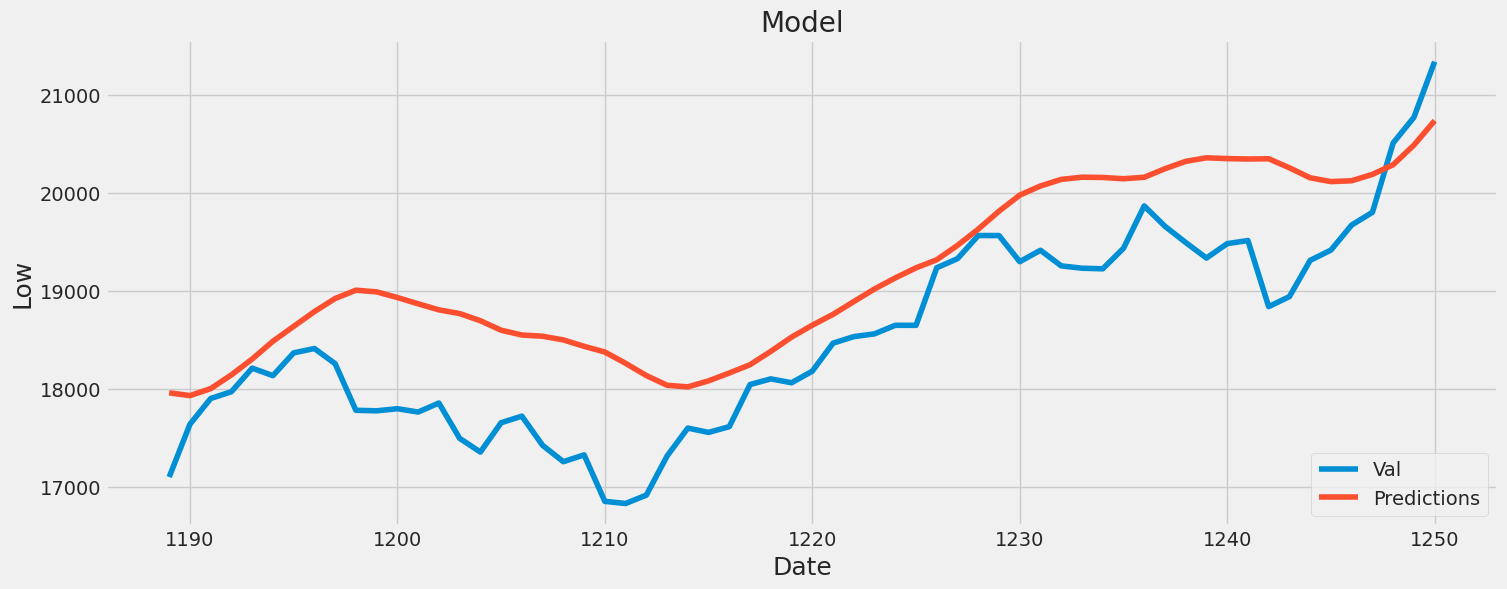

In [ ]:
# Plot the data
import matplotlib.pyplot as plt
train1 = data1[:training_data_len1]
valid1 = data1[training_data_len1:]
valid1['Predictions'] = predictions1
low=valid1['Predictions']
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Low', fontsize=18)

plt.plot(valid1[['Low', 'Predictions']])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()

848.6701620479469


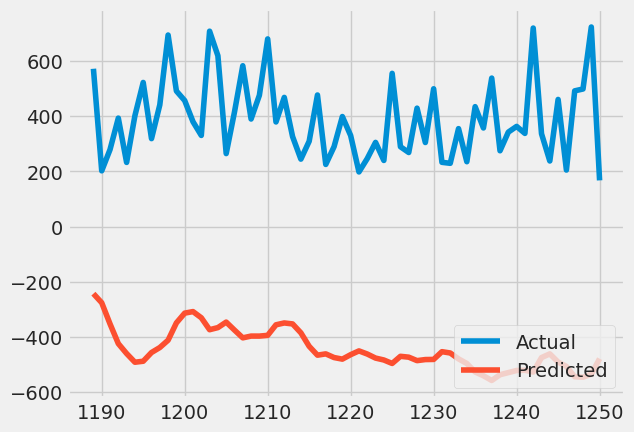

In [ ]:
rmserange = np.sqrt(np.mean((((dataset-dataset1).reshape(-1)[-62:] - (high-low)) ** 2)))
print(rmserange)
plt.plot(pd.DataFrame({"actual":(dataset-dataset1).reshape(-1)[-62:],"predicted":high-low}))
plt.legend([ 'Actual', 'Predicted'], loc='lower right')
plt.show()